# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [19]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})
# Drop irrelevant or non-functional trait columns
#dat = dat.drop(columns=['']) all are relevant to ecology, biology and behavior for location
# Drop columns with more than 40% missing values
threshold = 0.4
dat = dat.loc[:, dat.isnull().mean() < threshold]
# Print final dataframe shape
print(f"Final DataFrame shape:{dat.shape} ")

Final DataFrame shape:(214, 17) 


In [20]:
print(dat.columns)

Index(['AdultBodyMass', 'Diet_Invertebrates', 'Diet_Vertebrates',
       'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants',
       'Diet_Other', 'HabitatBreadth', 'ActivityCycle', 'ForagingStratum',
       'LitterSize', 'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'],
      dtype='object')


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [21]:
# Identify categorical and numerical columns
categorical_columns = dat.select_dtypes(include=['object']).columns
numerical_columns = dat.select_dtypes(exclude=['object']).columns
# Impute categorical variables with mode
for column in categorical_columns:
    dat[column] = dat[column].fillna(dat[column].mode()[0])
# Impute numerical variables with KNN
knn_imputer = KNNImputer(n_neighbors=5)
dat[numerical_columns] = knn_imputer.fit_transform(dat[numerical_columns])
# Verify no missing values
print(dat.isnull().sum())

AdultBodyMass         0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
dtype: int64


### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [22]:
# Create the target variable 'nClimates' as the sum of climate type columns
dat['nClimates'] = (dat[['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']].sum(axis=1))
# Drop the original climate type columns
dat = dat.drop(columns=['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'])
# Encode categorical variables (if any categorical variables remain)
categorical_columns = dat.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    dat[col] = label_encoder.fit_transform(dat[col].fillna(dat[col].mode()[0]))  # Impute with mode
# Split the dataset into features (X) and target (y)
X = dat.drop(columns=['nClimates'])
y = dat['nClimates']
# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=808)
print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (149, 12), Testing data shape: (65, 12)


### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

Decision Tree Mean Squared Error: 1.5096265393417696


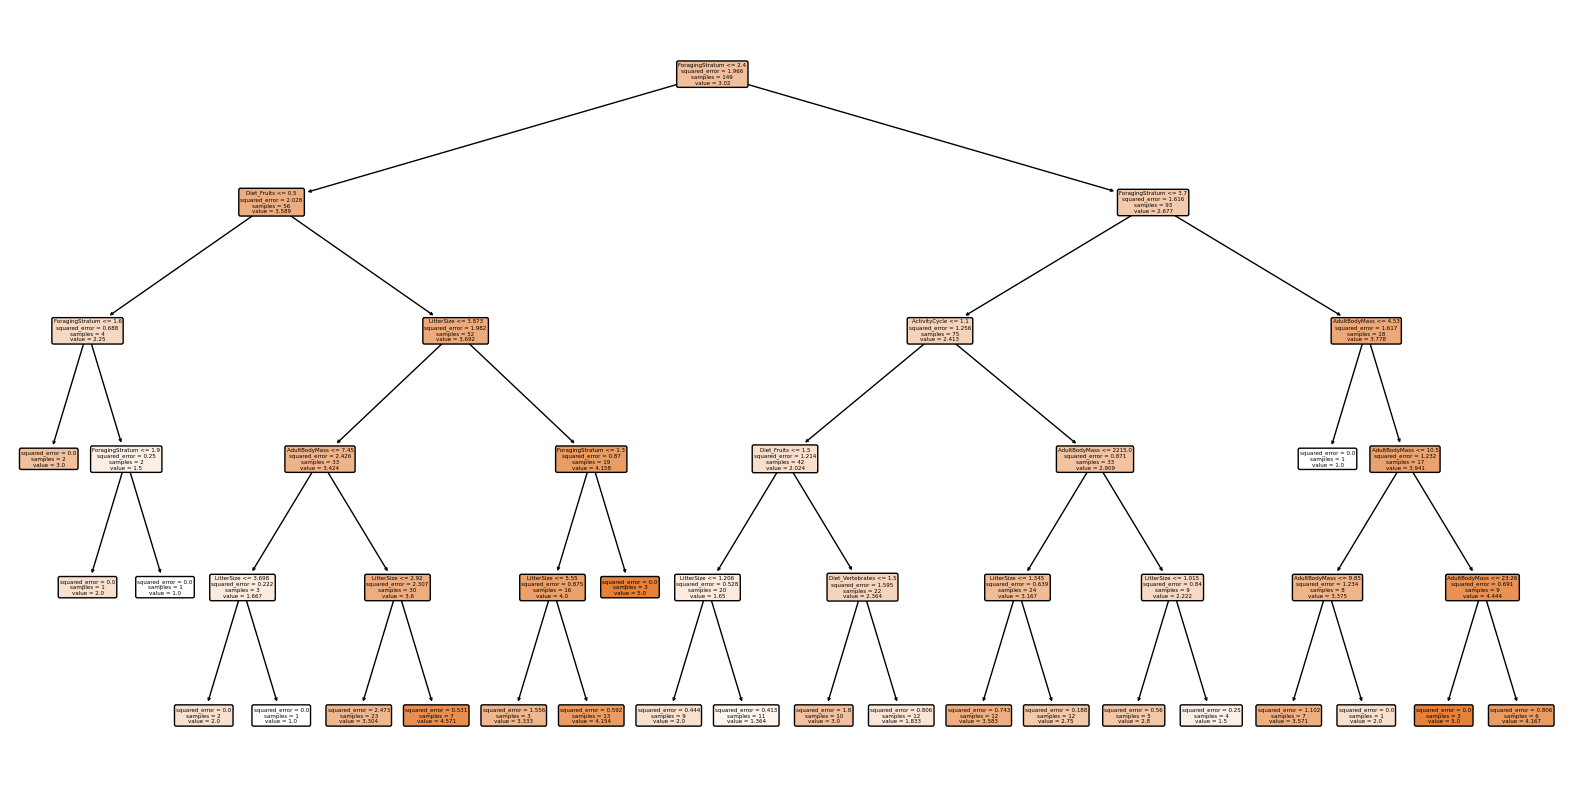

In [24]:
# Initialize the DecisionTreeRegressor with a max depth of 5
dt_regressor = DecisionTreeRegressor(max_depth=5, random_state=808)
# Train the model
dt_regressor.fit(X_train, y_train)
# Make predictions
y_pred_dt = dt_regressor.predict(X_test)
# Evaluate the performance using mean squared error
mse_dt = mean_squared_error(y_test, y_pred_dt)
print(f"Decision Tree Mean Squared Error: {mse_dt}")
# Visualize the trained decision tree
plt.figure(figsize=(20,10))
plot_tree(dt_regressor, feature_names=X.columns, filled=True, rounded=True)
plt.show()

Based on the way this tree looks, what would you guess the most important variable to be?

*The most important variable in the decision tree is Foraging Stratum because it is at the root node and multiple level splits. From the root node levels split into other variables, on the  Foraging stratum shows up again up to the 4th split. This means it provides the highest information gain in predicting the number of climate types a species inhabits. Diet_Seeds is influential as it appears as a secondary split but does not continue to appear.*

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [30]:
# Define a parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 4, 5, 6, 7],  # Max depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf
    'max_features': ['sqrt', 6, None]  # Number of features to consider at each split
}
# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=808)
# Initialize GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
# Perform Grid Search
grid_search.fit(X_train, y_train)
# Get the best parameters from GridSearchCV
print(f"Best Parameters: {grid_search.best_params_}")
# Train the best Random Forest model
best_rf = grid_search.best_estimator_
# Make predictions with the optimized model
y_pred_rf = best_rf.predict(X_test)
# Evaluate the model with MSE
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error: {mse_rf}")

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Random Forest Mean Squared Error: 1.450774322778164


### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

Best Parameters from GridSearchCV: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Random Forest Mean Squared Error: 1.451


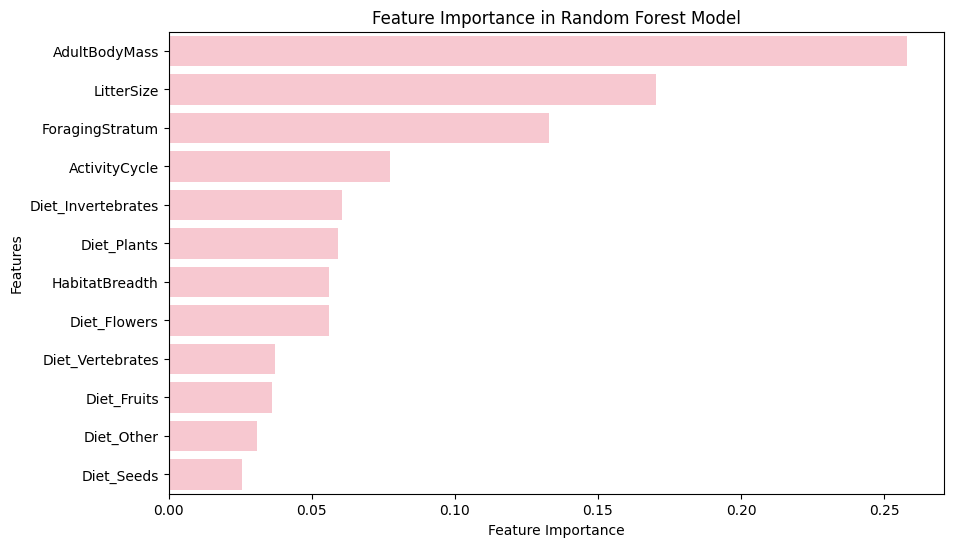

In [35]:
# Make predictions with the optimized random forest model
y_pred_rf = best_rf.predict(X_test)
# Print the best parameters from GridSearchCV
print(f"Best Parameters from GridSearchCV: {grid_search.best_params_}")
# Compute and print MSE to evaluate model performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error: {mse_rf:.4}")
# Extract feature importance from the trained random forest model
feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
# Create a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, color = "pink")
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Model')
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

*The random forest model we made had better accuracy than the single decision tree. We can tell from the lower mean squared error. The single decision tree had foraging startum as most influential, while the random forest model has Adult Body Mass as most influential. The most influential traits for species' climate adaptability were Adult Body Mass, Litter Size, ForagingStratum, ActivityCycle, and Diet_Seeds, indicating that where and when a species forages, its size, along with its litter size and dietary habits play an important role in determining its ability to inhabit multiple climates.*